In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy.ndimage import convolve
from scipy import signal
import matplotlib.animation as animation
import warnings
import json
import scipy
import os

import discrete_simulation_methods as ds

In [2]:
params= {"Nh": 100000, "N0": 1000, "R0": 5, "M": 1, "D": 3, "dc": 5, "mu": 1, "gamma_shape": 20, "r": 10}
sim_params = {"xdomain": 100, "dx": 1, "t0": 0, "tf": 100, "dt": 0.1, "noise_mean": 0, "noise_std": 0.1, "initial_mean": [0, 0], "initial_var": 5, "n_step_prior": 5, "folder_name": "simulation#16", "conv_size": 20}

In [3]:
x_range = sim_params["xdomain"] #Initialize the spaces
dx = sim_params["dx"]
x_linspace = np.arange(-x_range, x_range, dx)
x_size = np.size(x_linspace)
sim_params["x_size"] = x_size

t_size = (sim_params["tf"]-sim_params["t0"])/sim_params["dt"]

s = np.zeros([x_size, x_size], dtype=int)
n = np.zeros([x_size, x_size], dtype=int) 
nh = np.zeros([x_size, x_size], dtype=int) #nh(x,t) = Nh*h(x,t) there should be a total of Nh*M elements 
coordmap = np.meshgrid(x_linspace, x_linspace) #coordmap is kinda stupid since we are not in any real space
c = nh.copy() # c is unused (supposed to be coverage)

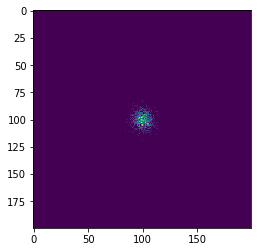

In [4]:
n0 = np.zeros(n.size, dtype=int) #Initial value of n0, initialized with a gaussian distributed

N0 = int(params["N0"])
initial_position = sim_params["initial_mean"]
initial_var = sim_params["initial_var"]

x_map = coordmap[0]
y_map = coordmap[1]

rsqrd = (x_map-initial_position[0])**2 + (y_map-initial_position[0])**2

p0 = np.exp(-rsqrd/(2*(initial_var**2)))
p0 = p0/np.sum(p0) # initial prob distribution for n: Gaussian dist

p0 = p0.ravel()

for i in range(N0):
    index = np.random.choice(n.size, p=p0) #Should really have a better way of doing this, this is extremely slow: maybe MPI?
    n0[index] += 1

n = copy.deepcopy(n0.reshape(n.shape)) #Make a deepcopy to seperate the two functions
plt.figure()
plt.imshow(n)

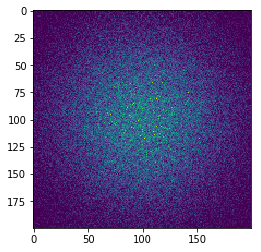

In [5]:
nh0 = np.zeros(nh.size, dtype=int) #Similarly, this is the initial value for nh

Nh = int(params["Nh"])
M = int(params["M"])

initial_position = sim_params["initial_mean"]
initial_var = 10*sim_params["initial_var"] #just 10 times the variance of n0, maybe change this?

x_map = coordmap[0]
y_map = coordmap[1]

rsqrd = (x_map-initial_position[0])**2 + (y_map-initial_position[0])**2

p0 = np.exp(-rsqrd/(2*(initial_var**2)))
p0 = p0/np.sum(p0) # initial prob distribution for n: Gaussian dist

p0 = p0.ravel()

for i in range(Nh*M):
    index = np.random.choice(nh.size, p=p0) #similarly, this is really slow
    nh0[index] += 1

nh = copy.deepcopy(nh0.reshape(nh.shape))
plt.figure()
plt.imshow(nh)

In [9]:
nh = nh0.reshape(nh.shape)
n = n0.reshape(n.shape) # In time 

t_start = sim_params["t0"] #Time parameters
t_stop = sim_params["tf"]
t_step = sim_params["dt"]

frames_n = [] #Store the frames as gifs
frames_nh = []
frames_f = []
times = []

N = []

for t in np.arange(t_start, t_stop, t_step):

    f = ds.fitness_controlled(n, nh, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
    n = ds.virus_growth(n, f, params, sim_params) #update
    n = ds.mutation(n, params, sim_params)

    nh = ds.immunity_gain(nh, n) #update nh
    nh = ds.immunity_loss(nh, n)

    current_N = np.sum(n)
    current_Nh = np.sum(nh)
    
    frames_nh.append([nh])
    frames_f.append([f])
    frames_n.append([n])
    times.append([t])
    N.append([current_N])

    n_step_prior = sim_params["n_step_prior"]

    print("Time: %2.2f, current_N : %d" % (t, current_N))

    if (current_N > current_Nh/2) and (t > (t_stop - t_start)/2):
        print("Population Reset")
        break
        # del frames_n[-n_step_prior:]
        # del frames_nh[-n_step_prior:]
        # del frames_f[-n_step_prior:]
        # del times[-n_step_prior:]

        # old_time = times[-1][0]
        # n = frames_n[-1][0]
        # nh = frames_nh[-1][0]

    if (current_N == 0):
        print("Population Death")
        break

Time: 0.00, current_N : 1017
Time: 0.10, current_N : 1026
Time: 0.20, current_N : 1012
Time: 0.30, current_N : 996
Time: 0.40, current_N : 1011
Time: 0.50, current_N : 1042
Time: 0.60, current_N : 1054
Time: 0.70, current_N : 1068
Time: 0.80, current_N : 1059
Time: 0.90, current_N : 1118
Time: 1.00, current_N : 1111
Time: 1.10, current_N : 1122
Time: 1.20, current_N : 1093
Time: 1.30, current_N : 1047
Time: 1.40, current_N : 1046
Time: 1.50, current_N : 1037
Time: 1.60, current_N : 1067
Time: 1.70, current_N : 1036
Time: 1.80, current_N : 1097
Time: 1.90, current_N : 1108
Time: 2.00, current_N : 1129
Time: 2.10, current_N : 1051
Time: 2.20, current_N : 1030
Time: 2.30, current_N : 1071
Time: 2.40, current_N : 1098
Time: 2.50, current_N : 1098
Time: 2.60, current_N : 1074
Time: 2.70, current_N : 1098
Time: 2.80, current_N : 1153
Time: 2.90, current_N : 1166
Time: 3.00, current_N : 1210
Time: 3.10, current_N : 1258
Time: 3.20, current_N : 1221
Time: 3.30, current_N : 1209
Time: 3.40, cur

MovieWriter ffmpeg unavailable. Trying to use pillow instead.
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
MovieWriter ffmpeg unavailable. Trying to use pillow instead.
MovieWriter ffmpeg unavailable. Trying to use pillow instead.


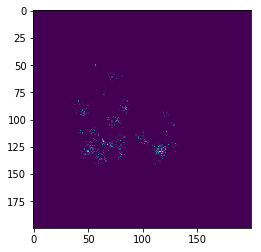

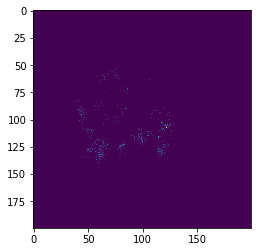

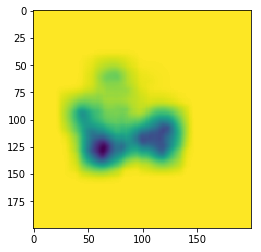

In [10]:
sim_params["folder_name"] = "simulation#16"
os.mkdir(sim_params["folder_name"])
os.chdir(sim_params["folder_name"])

ds.write2json("", params, sim_params)
ds.makeGif(frames_n, "n_simulation")
ds.makeGif(frames_nh, "nh_simulation")
ds.makeGif(frames_f, "f_simulation")

os.chdir("../")

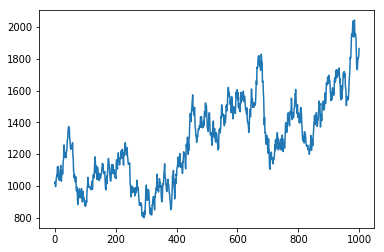

In [11]:
plt.plot(N)

In [ ]:
def update(n, nh): #Used for debugging

    f = ds.fitness(nh, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
    n = ds.virus_growth(n, f, params, sim_params) #update n
    n = ds.mutation(n, params, sim_params)

    nh = ds.immunity_gain(nh, n) #update nh
    nh = ds.immunity_loss(nh, n)

    return n, nh